In [1]:
import os
import imageio
import skimage.transform
import numpy as np
import pandas as pd
import tifffile
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import cv2
from PIL import Image
import math

In [3]:
                                                        #Set Paths

#movies
movie_low = '/Users/djuanm/Documents/Behavior_Analysis /Videos/M181-20241215-185048-lower-camera.mp4'
movie_side = '/Users/djuanm/Documents/Behavior_Analysis /Videos/M181-20241215-185048-side-camera.mp4'
movie_upper = '/Users/djuanm/Documents/Behavior_Analysis /Videos/M181-20241215-185048-upper-camera.mp4'

#CSVs
csv_low = '/Users/djuanm/Documents/Behavior_Analysis /Data/M181-20241215-185048-lower-camera.csv'
csv_side = '/Users/djuanm/Documents/Behavior_Analysis /Data/M181-20241215-185048-side-camera.csv'
csv_upper = '/Users/djuanm/Documents/Behavior_Analysis /Data/M181-20241215-185048-upper-camera.csv'

plots = '/Users/djuanm/Documents/Behavior_Analysis /Plots/'

view =['low','side','top']
movies = [movie_low,movie_side,movie_upper]

In [5]:
for movie in movies:
    if 'low' in movie:
        
        # Load up frames
        frame_fraction = 0.2
        seconds_to_save = 20#60
        
        #Load video
        vid = imageio.get_reader(movie, 'ffmpeg')
        
        #Get fps, length, start frmae
        fps = vid.get_meta_data()['fps']
        length = fps*vid.get_meta_data()['duration']
        start_frame = int(frame_fraction * length)
        
        #initialize list to save each image in a frame
        stack_to_save = []
        rng = np.arange(int(start_frame), int(start_frame + fps*seconds_to_save))
        
        #Save each frame from video as image - tqdm just adds a progress bar
        for stk in tqdm(rng):
            stack_to_save.append(vid.get_data(stk))
        
        
        
        # Save out frames as image
        img_low_list = []
        
        #Converts each image to a single tif file with each image
        with tifffile.TiffWriter(os.path.split(movie)[0] + os.path.sep + os.path.split(movie)[1][:-4] + '-chunk.tif', imagej=True) as tif:
            for img in tqdm(stack_to_save):
                 tif.write(img, contiguous=True)
        
        
                                                #Load frames and images into dataframe - 9/10
        
        #Label each frame and save into dataframe
        frame_num = list(range(len(stack_to_save)))
        frame_list = []
        for i in frame_num:
            frame_name = 'frame' + str(frame_num[i])
            frame_list.append(frame_name)
        
        #Create DataFrame
        df = pd.DataFrame()
        df['Frame_number'] = frame_list
        df['Frame_array'] = stack_to_save

    
                                                    #Create ROI - 9/10
                                                         
        #Select random frame to choose ROI - roi in terms of [Top_Left_X, Top_Left_Y, Width, Height]
        random_frame = df.sample()
        img = random_frame['Frame_array'].iloc[0]
        roi = cv2.selectROI('Select ROI', img, showCrosshair=True, fromCenter=False)
        cv2.waitKey(0) 
        cv2.destroyAllWindows()
        
        #Get beginning and end indices for roi width
        roi_x1 = roi[0]
        roi_x2 = roi_x1 + roi[2]
        
        #Get beginning and end indices for roi height
        roi_y1 = roi[1]
        roi_y2 = roi_y1 + roi[3]
        

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/26/vr_6h6_91zqdvg27bv5t8kgc0000gp/T/ipykernel_2497/1276729402.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ME = np.abs(cropped_image - offset_image)


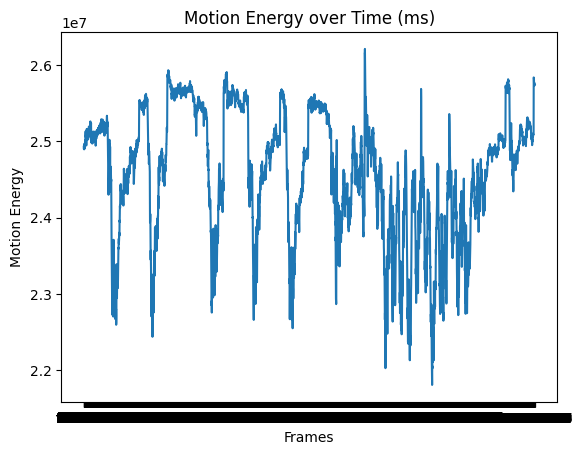

In [7]:
#Iterate and save over different movies - then compare avg motion energy between sections of the graph 
images  = df['Frame_array']
frames = df['Frame_number']
time = (np.linspace(0,(len(frames) * fps),len(frames)))

#Calculate Motion Energy 
ME_list = []

for image in images:

    #Crop Image 
    cropped_image = image[roi_x1:roi_x2,roi_y1:roi_y2,:] 

    #Offset images 
    offset_image = cropped_image[1:,:,:]
    cropped_image = cropped_image[:-1,:,:]

    #Take absolute value of differences
    ME = np.abs(cropped_image - offset_image)

    #Sum all dimensions together 
    ME = np.sum(ME,axis = (0,1,2))
    
    ME_list.append(ME)

len(frames)
plt.plot(frames,ME_list)
plt.xlabel('Frames')
plt.ylabel('Motion Energy')
plt.title('Motion Energy over Time (ms)')
plt.show()

In [103]:
#Find the average motion energy in specific bins instead of looking between timepoints bc my computer will explode

bin_size = int(len(ME_array) / 40)

#Look at every 100 frames
ranges = []
starts = []
avg_ME  = []


for j in range(bin_size):
    start = j*bin_size 
    end = start + bin_size 
    if end <= len(ME_array):
        ranges.append(range(start,end))
        starts.append(start)

for r in ranges:
    avg_ME.append(np.mean(ME_array[r]))

plt.plot(frames,ME_list, label = 'Motion Energy', alpha = 0.5, label = 'Motion Energy' )
plt.scatter(starts,avg_ME, color = 'red', label = 'Average ME every 100 frames', alpha = 1)

plt.legend()
plt.xlabel('Frames')
plt.ylabel('Motion Energy')
plt.title('Motion Energy over Time (ms) - Average ME every 100 bins')
plt.show()


[np.float64(18880209.85),
 np.float64(18976940.5),
 np.float64(18182315.39),
 np.float64(18395720.01),
 np.float64(18773928.94),
 np.float64(18880161.98),
 np.float64(18161387.28),
 np.float64(18982606.54),
 np.float64(19226102.92),
 np.float64(19173066.1),
 np.float64(19077004.36),
 np.float64(18144996.61),
 np.float64(18958396.59),
 np.float64(19181632.74),
 np.float64(18887601.08),
 np.float64(18193381.81),
 np.float64(18650742.39),
 np.float64(18939974.7),
 np.float64(18019730.51),
 np.float64(18597885.48),
 np.float64(19110556.73),
 np.float64(18981096.3),
 np.float64(18352763.21),
 np.float64(18490157.08),
 np.float64(18623987.86),
 np.float64(18742820.79),
 np.float64(17968562.07),
 np.float64(18032196.11),
 np.float64(17697693.94),
 np.float64(18054002.52),
 np.float64(17962179.93),
 np.float64(17920906.89),
 np.float64(18348355.61),
 np.float64(17956961.93),
 np.float64(18301435.98),
 np.float64(18484152.96),
 np.float64(18743751.96),
 np.float64(18988111.02),
 np.float64(1876

Mersenne function - 
Seed - is the initial condition for the random number generator 

put a seed at the top anytime you use randomness 
np.random.seed(200)

Could index instead of deleting 

In [42]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 26.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [46]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.power import TTestIndPower as power


np.random.seed(201)

In [76]:
#calculation of effect size
# size of samples in pilot study
n1, n2 = 4, 4

# variance of samples in pilot study
s1, s2 = 5**2, 5**2


mean1 = 90
mean2 = 85
# calculate the pooled standard deviation 
# (Cohen's d)
s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

es = (mean1 - mean2)/ s

#Do a power analysis to find number of observations needed to get 80% power. need to have power().solve_power exactly
from statsmodels.stats.power import TTestIndPower as power
solve = power().solve_power(effect_size = es,nobs1 = None, alpha = 0.05, power = 0.8, ratio = 1, alternative = 'two-sided')
print(f' Need {solve} samples to achieve 80% power')

 Need 16.714722446954013 samples to achieve 80% power


16.714722446954013

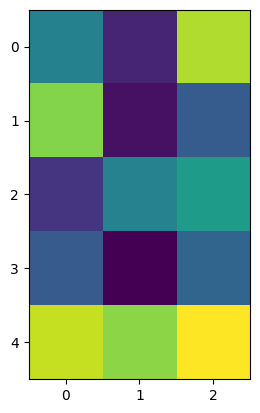

In [37]:
x = np.random.rand(5,10,1000)

plt.imshow(x[:,:,5])

cropped = x[:,1:4,0:3]
plt.imshow(x[:,1:4,4])

In [230]:
#Can only take 4000 frame chunks, trying to do the whole thing will blow my computer up. Look at motionenergy between chunks of the 4000
len(stack_to_save)
int(start_frame + fps*seconds_to_save)
type(stk)
rng

array([350050, 350051, 350052, ..., 354047, 354048, 354049], shape=(4000,))

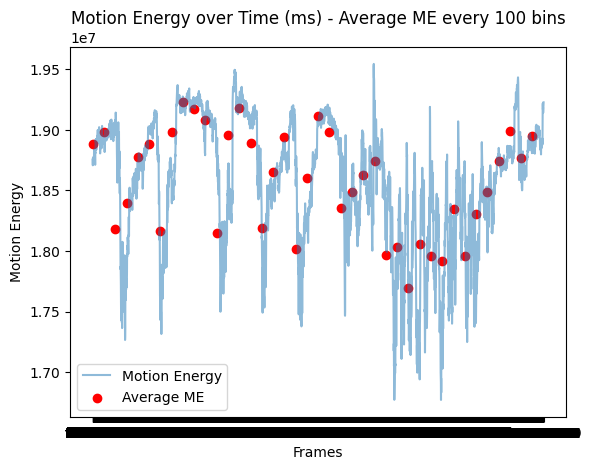

In [111]:
plt.plot(frames,ME_list, label = 'Motion Energy', alpha = 0.5)
plt.scatter(starts,avg_ME, color = 'red', label = 'Average ME', alpha = 1)

plt.legend()
plt.xlabel('Frames')
plt.ylabel('Motion Energy')
plt.title('Motion Energy over Time (ms) - Average ME every 100 bins')
plt.show()